## GAN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


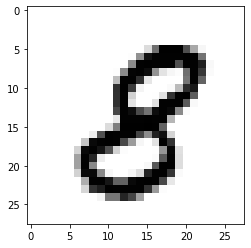

In [3]:
plt.imshow(mnist.train.images[5].reshape(28,28),cmap='Greys')

## The Networks

### The Generator

In [4]:
N = 784
nz = 100

In [5]:
def generator(z, reuse=None):
    with tf.variable_scope('gen', reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z, units=128)
        
        # tf.nn.leaky_relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # second layer
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha * hidden2, hidden2)
        
        #
        output = tf.layers.dense(inputs=hidden2, units=N)
        # activation
        output = tf.nn.tanh(output)
        
        return output

## The discriminator

In [6]:
def discriminator(X, reuse=None):
    with tf.variable_scope('dis', reuse=reuse):
        
        # number of units ??
        hidden1 = tf.layers.dense(inputs=X, units=128)
        
        # tf.nn.leaky_relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # second layer
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha * hidden2, hidden2)
        
        #
        logits = tf.layers.dense(inputs=hidden2, units=1)
        # activation
        output = tf.nn.sigmoid(logits)
        
        return output, logits

In [7]:
tf.reset_default_graph()

### Placerholder for images and noise

In [8]:
real_images = tf.placeholder(tf.float32, shape=(None, N))

# 100 or 128
z = tf.placeholder(tf.float32, shape=(None, nz))

## Generator

In [9]:
G = generator(z)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


## Discriminator
### Training on real images first!

In [10]:
D_output_real, D_logits_real = discriminator(real_images)

### Running discrimator twice, reuse variables

In [11]:
D_output_fake, D_logits_fake = discriminator(G, reuse=True)

## Losses (helper function)

In [12]:
def loss_func(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in, labels=labels_in))

### discriminator loss when trained on real data

### (target is not class but real or not)

In [13]:
# same shape tensor. Half Real and Half Fake?
# add smoothing, make discriminator genearlize better

smoothing_factor = 0.9
D_real_loss = loss_func(logits_in=D_logits_real, labels_in=tf.ones_like(D_logits_real) * smoothing_factor)

# fake
# no smoothing_factor = ?? 
D_fake_loss = loss_func(logits_in=D_logits_fake, labels_in=tf.zeros_like(D_logits_fake))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
D_loss = D_real_loss + D_fake_loss

## Generator loss

## flip label

In [15]:
G_loss = loss_func(logits_in=D_logits_fake, labels_in=tf.ones_like(D_logits_fake))

## Optimizer

In [16]:
learning_rate = 1e-3

### one optimzer for each (discriminator, generator)

### -> collection variables first

In [17]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']


In [18]:
D_trainer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(D_loss, var_list=d_vars)

In [19]:
G_trainer =  tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(G_loss, var_list=g_vars)

In [20]:
d_vars

[<tf.Variable 'dis/dense/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/bias:0' shape=(1,) dtype=float32_ref>]

## Training Session

In [21]:
## parameters
batch_sz = 100

In [22]:
X_train = mnist.train.images
n_batches = len(X_train) // batch_sz

### Reshape and Rescale images
from (0, 1) to (-1, 1), to be consistant with tanh activation function of the generator

In [23]:
X1 = X_train[:batch_sz]
X1.shape

(100, 784)

In [24]:
X1.max()

1.0

In [25]:
X_train = X_train * 2 - 1

In [26]:
## initializer

In [27]:
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=g_vars)

In [28]:
epochs = 500
samples = []

In [29]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(epochs):
        for j in range(n_batches):
            X_batch = X_train[j*batch_sz : (j+1)*batch_sz]
            
            # genearte fake images
            batch_z = np.random.uniform(-1, 1, size=(batch_sz, nz))
            
            # run optimizer, not saving any ouput
            sess.run(D_trainer, feed_dict={real_images:X_batch, z:batch_z})
            # 
            sess.run(G_trainer, feed_dict={z: batch_z})
            
        print(f"On epoch {i} / {epochs}")
        
        # get a sample from generator when training
        random_z = np.random.uniform(-1, 1, size=(1, nz))
        sample_img = sess.run(generator(z, reuse=True), feed_dict={z: random_z})
        
        samples.append(sample_img)
        saver.save(sess, './models/500_epoch_model.ckpt')

On epoch 0 / 500
On epoch 1 / 500
On epoch 2 / 500
On epoch 3 / 500
On epoch 4 / 500
On epoch 5 / 500
On epoch 6 / 500
On epoch 7 / 500
On epoch 8 / 500
On epoch 9 / 500
On epoch 10 / 500
On epoch 11 / 500
On epoch 12 / 500
On epoch 13 / 500
On epoch 14 / 500
On epoch 15 / 500
On epoch 16 / 500
On epoch 17 / 500
On epoch 18 / 500
On epoch 19 / 500
On epoch 20 / 500
On epoch 21 / 500
On epoch 22 / 500
On epoch 23 / 500
On epoch 24 / 500
On epoch 25 / 500
On epoch 26 / 500
On epoch 27 / 500
On epoch 28 / 500
On epoch 29 / 500
On epoch 30 / 500
On epoch 31 / 500
On epoch 32 / 500
On epoch 33 / 500
On epoch 34 / 500
On epoch 35 / 500
On epoch 36 / 500
On epoch 37 / 500
On epoch 38 / 500
On epoch 39 / 500
On epoch 40 / 500
On epoch 41 / 500
On epoch 42 / 500
On epoch 43 / 500
On epoch 44 / 500
On epoch 45 / 500
On epoch 46 / 500
On epoch 47 / 500
On epoch 48 / 500
On epoch 49 / 500
On epoch 50 / 500
On epoch 51 / 500
On epoch 52 / 500
On epoch 53 / 500
On epoch 54 / 500
On epoch 55 / 500
On

In [30]:
import matplotlib.cm as cm

In [1]:
# # Compare original images with their reconstructions
# c = 5
# r = epochs // c
# # r  = 1

# f, axarr = plt.subplots(r, c, figsize=(15, 3 * r))
# # print(axarr.shape)
# for i in range(r):
#     for j in range(c):
#         idx = i*c + j
#         img = (samples[i*c + j] + 0.5) * 255
#         img = img.reshape(28, -1)
#         axarr[i,j].imshow(img, cmap="Greys", aspect=1)
#         axarr[i,j].axis('off')


In [32]:
# saver = tf.train.Saver(var_list=g_vars)

In [38]:
new_samples = []
n_new_samples = 30

with tf.Session() as sess:
    
    saver.restore(sess,'./models/500_epoch_model.ckpt')
    
    for x in range(n_new_samples):
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        new_samples.append(gen_sample)

INFO:tensorflow:Restoring parameters from ./models/500_epoch_model.ckpt


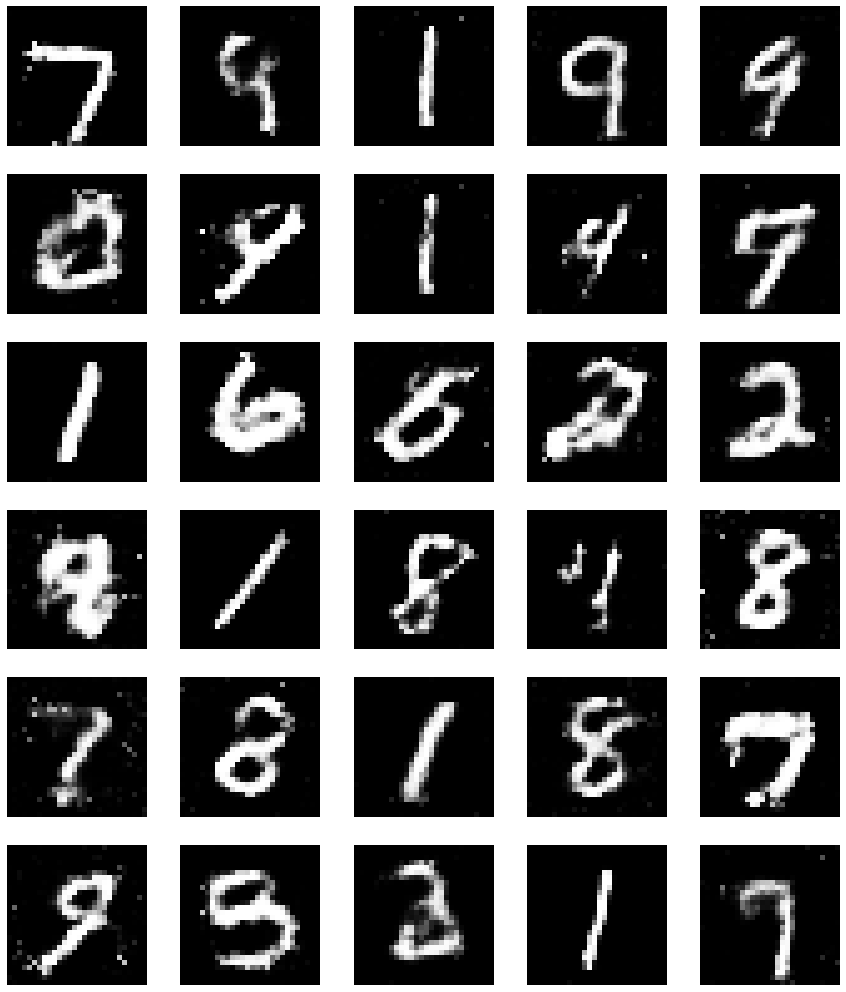

In [39]:
# Compare original images with their reconstructions
c = 5
r = n_new_samples // c

f, axarr = plt.subplots(r, c, figsize=(15, 3 * r))
# print(axarr.shape)
for i in range(r):
    for j in range(c):
        idx = i*c + j
        img = (new_samples[i*c + j] + 0.5) * 255
        img = img.reshape(28, -1)
        axarr[i,j].imshow(img, cmap="gray", aspect=1)
        axarr[i,j].axis('off')